## 1. 손글씨 도형
그림판으로 그린 손글씨 이미지 총 300개의 이미지를 다운로드 받습니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/DL/data/

/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/DL/data


In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/DL/data/shape.zip"

replace shape/test/cir/drawing(10).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace shape/test/cir/drawing(100).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/DL/data/shape/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/DL/data/shape/test"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor(),              # C W H + 0~1 사이로
    transforms.RandomInvert(1),         # 이미지를 랜덤하게 반전. 1은 항상 반전 (검정 <--> 흰색), 확률 : 1
    transforms.Normalize((0.5),(0.5))   # 표준화
])

In [ ]:
trainset = torchvision.datasets.ImageFolder(root=train_path, transform = transform)
testset = torchvision.datasets.ImageFolder(root=test_path, transform = transform)
len(trainset), len(testset)

(240, 60)

In [ ]:
trainset.__getitem__(10)

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [ ]:
trainset.classes, testset.classes

(['cir', 'tri', 'x'], ['cir', 'tri', 'x'])

In [ ]:
class_map = {
    0: 'cir',
    1: 'tri',
    2: 'x'
}

In [ ]:
loader = DataLoader(
    dataset=trainset,
    batch_size=64,
    shuffle=True,
)

imgs, labels = next(iter(loader))
print(imgs.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


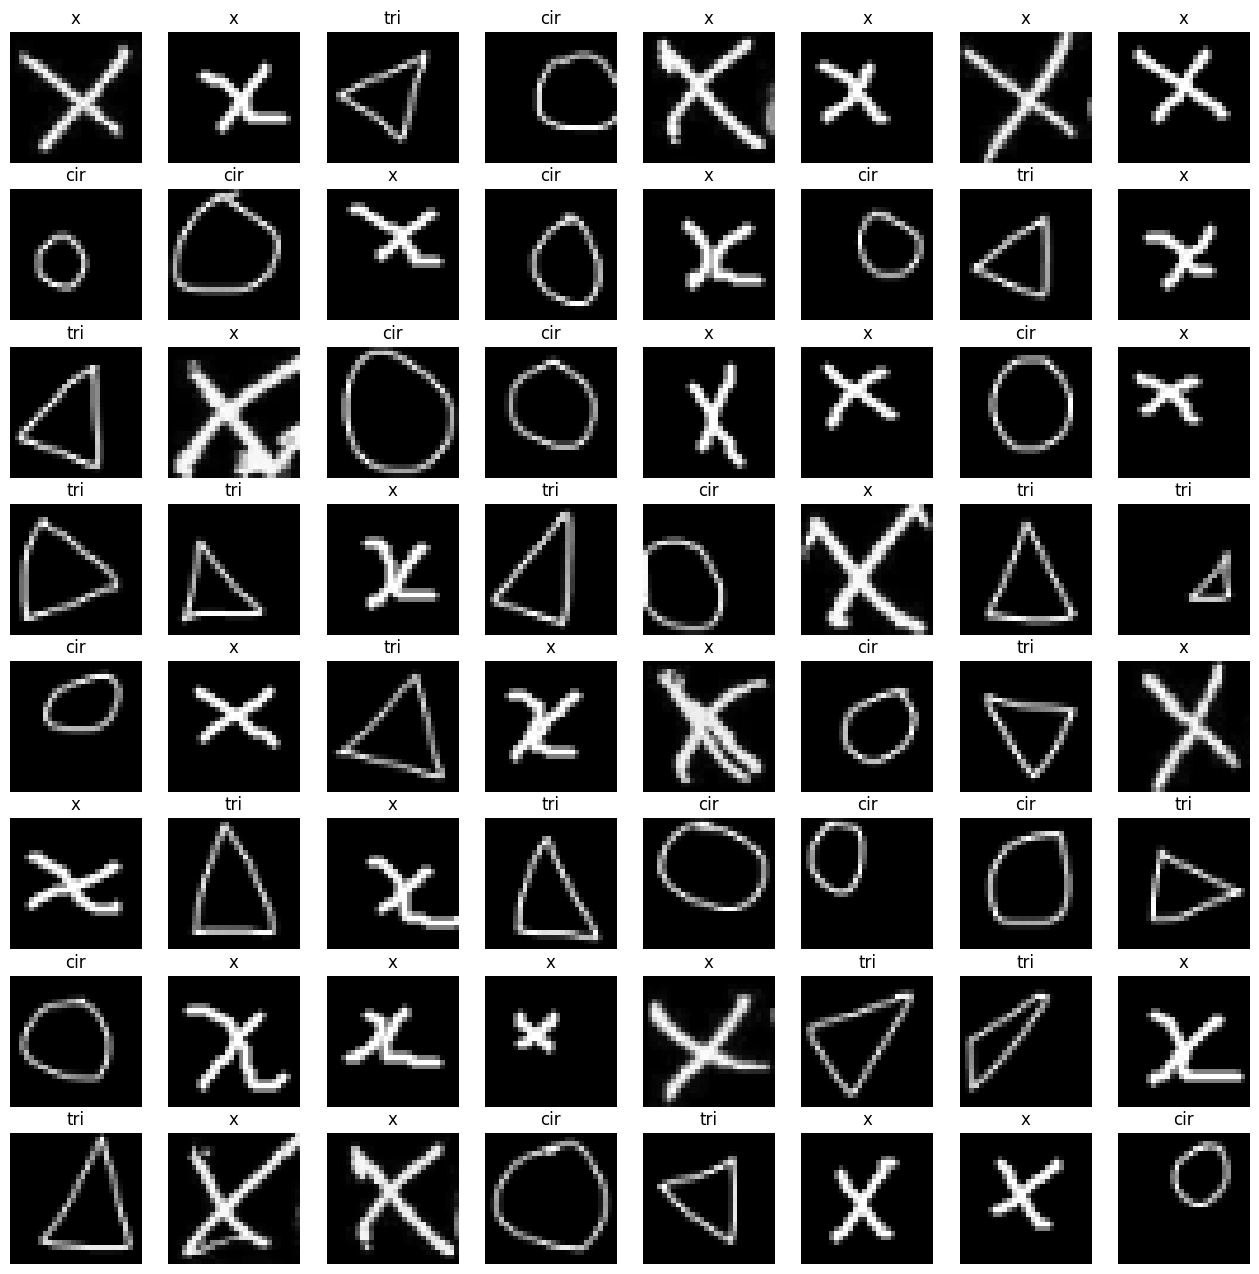

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [ ]:
# 장치 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 2. CNN 모델 만들기

In [ ]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(28, 28, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(28, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(56, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )
        self.Linear = nn.Linear(56 * 7 * 7, 3)

    def forward(self, x):
        x = self.classifier(x)
        x = self.flatten(x)
        output = self.Linear(x)
        return output

In [ ]:
model = ConvNeuralNetwork().to(device)
print(model)

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)


In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_loop(train_loader, model, loss_fn, optimizer):
    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(train_loader)
    avg_acc = sum_accs / len(train_loader)
    return avg_loss, avg_acc

In [ ]:
epochs = 50

for i in range(epochs):
    print(f"------------------------------------------------")
    avg_loss, avg_acc = train_loop(loader, model, loss, optimizer)
    print(f'Epoch {i:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')
print("Done!")

------------------------------------------------
Epoch    0/50 Loss: 1.098683 Accuracy: 33.46%
------------------------------------------------
Epoch    1/50 Loss: 1.033972 Accuracy: 60.68%
------------------------------------------------
Epoch    2/50 Loss: 0.793603 Accuracy: 69.14%
------------------------------------------------
Epoch    3/50 Loss: 0.480861 Accuracy: 81.38%
------------------------------------------------
Epoch    4/50 Loss: 0.371185 Accuracy: 82.16%
------------------------------------------------
Epoch    5/50 Loss: 0.321317 Accuracy: 83.07%
------------------------------------------------
Epoch    6/50 Loss: 0.315318 Accuracy: 84.11%
------------------------------------------------
Epoch    7/50 Loss: 0.243954 Accuracy: 88.67%
------------------------------------------------
Epoch    8/50 Loss: 0.241205 Accuracy: 88.28%
------------------------------------------------
Epoch    9/50 Loss: 0.191410 Accuracy: 91.41%
------------------------------------------------
E

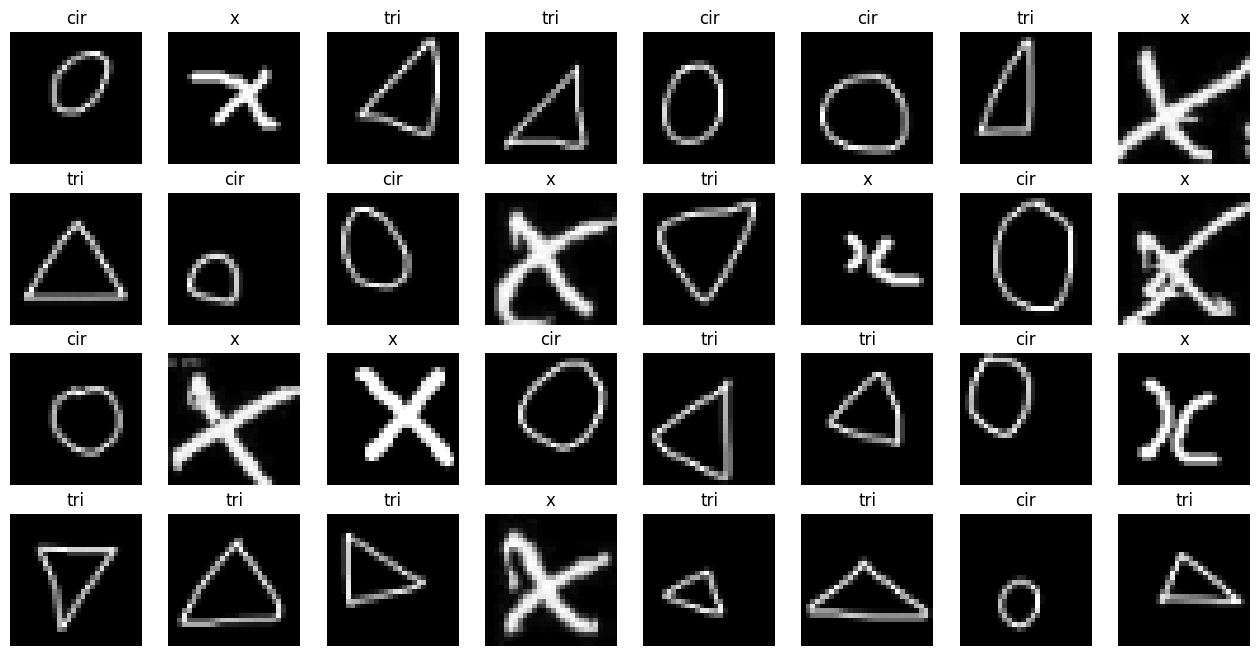

In [ ]:
# 테스트 데이터 로드
test_loader = DataLoader(
    dataset=testset,
    batch_size=32,
    shuffle=True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [ ]:
def test(model, loader):
    model.eval()

    sum_accs = 0

    img_list = torch.Tensor().to(device)
    y_pred_list = torch.Tensor().to(device)
    y_true_list = torch.Tensor().to(device)

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)

        # cat -> list와 index를 붙인다! dim = 0 행으로 줄줄이 붙인다.
        y_pred_list = torch.cat((y_pred_list, y_pred_index), dim=0)
        y_true_list = torch.cat((y_true_list, y_batch), dim=0)
        img_list = torch.cat((img_list, x_batch), dim=0)

        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs += acc

    avg_acc = sum_accs / len(loader)
    return y_pred_list, y_true_list, img_list, avg_acc

In [ ]:
y_pred_list, y_true_list, img_list, avg_acc = test(model, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 83.26% 입니다.


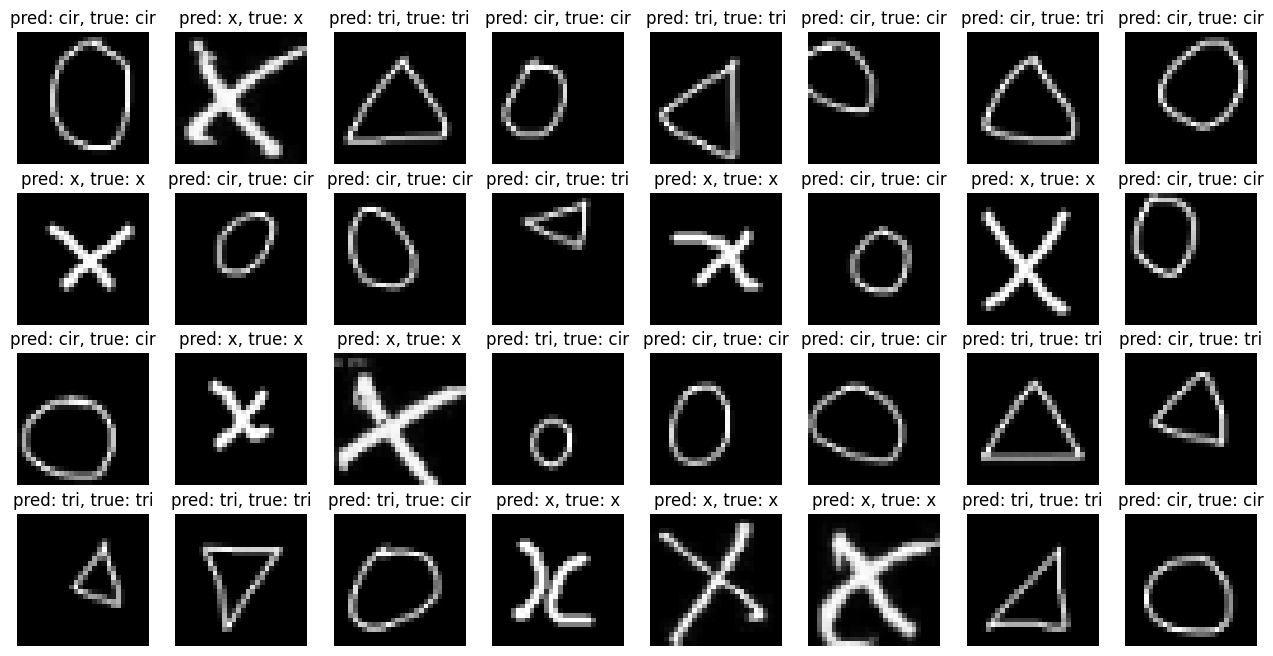

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

img_list_cpu = img_list.cpu()
y_pred_list_cpu = y_pred_list.cpu()
y_true_list_cpu = y_true_list.cpu()

for ax, img, y_pred, y_true in zip(axes.flatten(), img_list_cpu, y_pred_list_cpu, y_true_list_cpu):
  ax.imshow(img.reshape(28, 28), cmap='gray')
  ax.set_title(f'pred: {class_map[y_pred.item()]}, true: {class_map[y_true.item()]}')
  ax.axis('off')

plt.show()

## 3. 모델 저장하고 불러오기
모델의 구조가 저장되지 않으므로 모델 클래스 정의가 없으면 복원할 수 없음

### 모델의 가중치와 매개변수만 저장

In [ ]:
# 모델의 가중치와 매개변수만 저장
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model2 = ConvNeuralNetwork().to(device)     # 학습된게 아님
print(model2)

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)


In [ ]:
y_pred_list, y_true_list, img_list, avg_acc = test(model2, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 32.59% 입니다.


In [ ]:
model2.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
y_pred_list, y_true_list, img_list, avg_acc = test(model2, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 83.26% 입니다.


### 모델 전체 저장
모델 클래스와 가중치가 함께 저장되므로, 복원 시 모델 구조를 별도로 정의할 필요 없음

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model3 = torch.load('model.pth', weights_only = False)

In [ ]:
y_pred_list, y_true_list, img_list, avg_acc = test(model3, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 83.48% 입니다.
